# Exploratory Data Analysis

Quá trình phân tích khám phá dữ liệu (EDA) trong notebook này nhằm mục tiêu hiểu rõ đặc điểm log returns của các cổ phiếu blue-chip Việt Nam, kiểm tra chất lượng dữ liệu, và xác định các yếu tố rủi ro, phụ thuộc để phục vụ modeling GARCH/EVT/Copula.

**Các bước chính của EDA:**
1. **Chuẩn bị dữ liệu:** Tải dữ liệu giá đóng cửa, kiểm tra missing values, xử lý các giá trị bất thường (giá <= 0), và tính toán log returns cho từng mã cổ phiếu.
2. **Thống kê mô tả:** Tính các chỉ số cơ bản (mean, std, skewness, kurtosis, min/max, percentiles) để đánh giá phân phối log returns, mức độ biến động, tail risk và outlier.
3. **Kiểm định thống kê:** Thực hiện các test normality, ARCH effect, stationarity, autocorrelation để kiểm tra tính chất chuỗi thời gian và xác định sự cần thiết của các mô hình GARCH/EVT.
4. **Phân tích tương quan và phụ thuộc:** Vẽ ma trận tương quan, scatter plot matrix, rolling correlation để kiểm tra mối liên hệ giữa các mã, đánh giá hiệu quả đa dạng hóa và rủi ro hệ thống.
5. **Phân tích trực quan:** Vẽ các biểu đồ histogram, QQ-plot, ACF/PACF, time series plot, bar chart số ngày tăng/giảm để trực quan hóa đặc điểm dữ liệu và các hiện tượng volatility clustering, tail risk.
6. **Tổng hợp risk metrics:** Tính các chỉ số VaR, Sharpe ratio, autocorrelation, số ngày tăng/giảm để so sánh rủi ro và hiệu suất giữa các mã.

**Ý nghĩa:**
- EDA giúp phát hiện các đặc điểm quan trọng của dữ liệu tài chính thực tế: fat tails, volatility clustering, tail risk, sự phụ thuộc giữa các mã.
- Kết quả EDA là nền tảng để lựa chọn mô hình phù hợp (GARCH, EVT, Copula), xây dựng chiến lược đầu tư, và quản trị rủi ro hiệu quả.
- Các bước đều được giải thích chi tiết bằng markdown sau mỗi kết quả, giúp người đọc hiểu rõ ý nghĩa từng phân tích và ứng dụng thực tế.

# 1. Chuẩn bị Dữ liệu

**Mục tiêu:** Tải dữ liệu giá đóng cửa của 5 cổ phiếu blue-chip Việt Nam (HPG, VHM, MWG, MBB, FPT), tính log returns, xử lý dữ liệu, và kiểm tra chất lượng dữ liệu.

### Import Libraries và Setup

Chúng ta bắt đầu bằng việc import các thư viện cần thiết:
- **pandas, numpy**: Xử lý và tính toán dữ liệu
- **matplotlib, seaborn**: Vẽ biểu đồ và visualization
- **statsmodels**: Các test thống kê và time series analysis
- **data_prep**: Module tự viết chứa các function load data, tính log returns, và EVT diagnostics

Module `data_prep` được reload để đảm bảo sử dụng code mới nhất khi có thay đổi.

In [32]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import sys
sys.path.append('../src')

import data_prep
importlib.reload(data_prep)

from data_prep import (
    load_data, compute_log_returns, check_negative_or_zero, save_to_csv, engle_ng_tests, mean_residual_life, hill_plot
)

## Tải và xử lí dữ liệu giá đóng cửa của 5 cổ phiếu (10 năm gần nhất)

Đoạn code sử dụng hàm xử lí dữ liệu toàn diện `load_data()` đã được định nghĩa trong `data-prep.py`.

In [2]:
# Test với fix
data = load_data('../data/raw')

Found 55 files

=== FPT: 11 files ===
Processing Download Data - STOCK_VN_XSTC_FPT (1).csv
  Raw: 249 rows
  Format %m/%d/%Y: converted 249 dates
  Failed dates: 0
  Failed prices: 0
  Final: 249 rows
Processing Download Data - STOCK_VN_XSTC_FPT (10).csv
  Raw: 118 rows
  Format %m/%d/%Y: converted 118 dates
  Failed dates: 0
  Failed prices: 0
  Final: 118 rows
Processing Download Data - STOCK_VN_XSTC_FPT (2).csv
  Raw: 250 rows
  Format %m/%d/%Y: converted 250 dates
  Failed dates: 0
  Failed prices: 0
  Final: 250 rows
Processing Download Data - STOCK_VN_XSTC_FPT (3).csv
  Raw: 251 rows
  Format %m/%d/%Y: converted 251 dates
  Failed dates: 0
  Failed prices: 0
  Final: 251 rows
Processing Download Data - STOCK_VN_XSTC_FPT (4).csv
  Raw: 252 rows
  Format %m/%d/%Y: converted 252 dates
  Failed dates: 0
  Failed prices: 0
  Final: 252 rows
Processing Download Data - STOCK_VN_XSTC_FPT (5).csv
  Raw: 253 rows
  Format %m/%d/%Y: converted 253 dates
  Failed dates: 0
  Failed prices: 0
 

### Kết quả Load và Merge Data

In [3]:
# Kết quả merge
print("Merged Data Summary:")
for ticker, df in data.items():
    print(f"{ticker}: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")

# Combine tất cả thành 1 DataFrame  
if data:
    raw_data = pd.concat(list(data.values()), axis=1).sort_index()
    print(f"\nCombined DataFrame: {raw_data.shape}")
    print(f"Date range: {raw_data.index.min().date()} to {raw_data.index.max().date()}")
    print(f"Columns: {list(raw_data.columns)}")
else:
    raw_data = pd.DataFrame()

Merged Data Summary:
FPT: 2617 rows from 2015-01-05 to 2025-07-01
HPG: 2617 rows from 2015-01-05 to 2025-07-01
MBB: 2617 rows from 2015-01-05 to 2025-07-01
MWG: 2617 rows from 2015-01-05 to 2025-07-01
VIC: 2617 rows from 2015-01-05 to 2025-07-01

Combined DataFrame: (2617, 5)
Date range: 2015-01-05 to 2025-07-01
Columns: ['FPT_DATA', 'HPG_DATA', 'MBB_DATA', 'MWG_DATA', 'VIC_DATA']


Output trên cho thấy:
- **Số lượng observations**: Mỗi cổ phiếu có từ 2617 dòng dữ liệu (tương ứng 10 năm trading days)
- **Thời gian**: Dữ liệu từ khoảng 2009-2010 đến 2024
- **Combined DataFrame**: Kết hợp tất cả cổ phiếu thành 1 DataFrame với columns là closing prices của từng mã

Việc merge thành công cho thấy các file CSV đã được format và xử lý date column đúng cách.

### Kiểm tra missing values

In [4]:
print("Missingness Check:")

# Date overlap analysis
all_dates = set().union(*[set(df.index) for df in data.values()])
common_dates = set(data[list(data.keys())[0]].index)
for df in list(data.values())[1:]:
    common_dates &= set(df.index)

print(f"\nTotal unique dates: {len(all_dates)}")
print(f"Common dates across all: {len(common_dates)}")

# Missing data summary
for ticker, df in data.items():
    missing_pct = (len(all_dates) - len(df)) / len(all_dates) * 100
    print(f"{ticker}: {missing_pct:.1f}% missing")

Missingness Check:

Total unique dates: 2617
Common dates across all: 2617
FPT: 0.0% missing
HPG: 0.0% missing
MBB: 0.0% missing
MWG: 0.0% missing
VIC: 0.0% missing


### Data Cleaning và Tính Log Returns

**Bước quan trọng:**
1. **Validation Check**: Kiểm tra có giá đóng cửa <= 0 không (thường do lỗi data)
2. **Dropna Strategy**: Chỉ giữ lại ngày có ít nhất 2 cổ phiếu có data (thresh=2)
3. **Log Returns Calculation**: Tính log returns = ln(P_t / P_{t-1})

In [6]:
# Data cleaning và tính log returns
print("Validation Check:")

# Kiểm tra closing price <= 0
negative_rows = (data <= 0).any(axis=1).sum()
print(f"Rows with price <= 0: {negative_rows}")

# Clean data (remove invalid prices if any)
data = data.dropna(thresh=2)  # Keep if at least 2 tickers have data
if negative_rows > 0:
    data = data[(data > 0).all(axis=1)]

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna().round(6)

print(f"Final data: {data.shape} -> Log returns: {log_returns.shape}")
print(f"Date range: {log_returns.index.min().date()} to {log_returns.index.max().date()}")

# Save files
os.makedirs('../data/processed', exist_ok=True)
data.to_csv('../data/processed/price_cleaned.csv')
log_returns.to_csv('../data/processed/log_returns.csv')
print("Files saved to data/processed/")

Validation Check:
Rows with price <= 0: 0
Final data: (2617, 5) -> Log returns: (2616, 5)
Date range: 2015-01-06 to 2025-07-01
Files saved to data/processed/


## 2. Phân tích khám phá: Vẽ biểu đồ log returns và tính thống kê mô tả

In [8]:
log_returns.describe()

,FPT_DATA,HPG_DATA,MBB_DATA,MWG_DATA,VIC_DATA
count,2616.000000,2616.000000,2616.000000,2616.000000,2616.000000
mean,0.000882,0.000683,0.000759,0.000683,0.000590
std,0.015988,0.020704,0.018657,0.021188,0.018547
min,-0.072480,-0.072596,-0.072379,-0.072571,-0.072571
25%,-0.006732,-0.009757,-0.007339,-0.009071,-0.006911
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.008461,0.011216,0.009025,0.010385,0.006915
max,0.067609,0.067143,0.066932,0.067659,0.067659


### Diễn giải kết quả thống kê mô tả log returns

Bảng trên cho thấy đặc điểm cơ bản của log returns các cổ phiếu:
- **Mean gần 0**: Thị trường hiệu quả, không có xu hướng tăng/giảm rõ rệt trong dài hạn.
- **Std (volatility)**: HPG và MWG có độ biến động lớn nhất, FPT thấp nhất → HPG/MWG rủi ro hơn, FPT ổn định hơn.
- **Min/Max**: Tồn tại những ngày biến động cực đoan (có thể do sự kiện đặc biệt hoặc khủng hoảng).
- **Phân vị 25%/50%/75%**: Phân phối returns khá cân bằng quanh 0, median đều là 0.

In [9]:
# Tính các thống kê mô tả
desc_stats = log_returns.agg(['std', 'skew', 'kurtosis']).T
desc_stats

,std,skew,kurtosis
FPT_DATA,0.015988,-0.149367,3.716970
HPG_DATA,0.020704,-0.054555,1.792316
MBB_DATA,0.018657,-0.259998,3.095013
MWG_DATA,0.021188,-0.146548,2.226641
VIC_DATA,0.018547,0.201597,4.071568


### Diễn giải std, skew, kurtosis của log returns
- **Std (volatility):**
  - MWG và HPG có độ biến động lớn nhất (0.021, 0.021), FPT thấp nhất (0.016). Cổ phiếu biến động cao thường tiềm ẩn rủi ro lớn hơn nhưng cũng có tiềm năng lợi nhuận cao hơn.
- **Skewness (độ lệch):**
  - Đa số cổ phiếu có skew âm nhẹ (FPT, HPG, MBB, MWG), nghĩa là tail trái (giảm mạnh) dài hơn tail phải (tăng mạnh). VIC có skew dương (0.20), tức tail phải dài hơn, có nhiều ngày tăng mạnh bất thường.
- **Kurtosis (độ nhọn):**
  - FPT, VIC có kurtosis > 3 (fat tails), nghĩa là có nhiều ngày biến động cực đoan hơn so với phân phối chuẩn. HPG, MWG, MBB có kurtosis thấp hơn, tức ít extreme events hơn.

**Ý nghĩa:**
- Skew âm và kurtosis cao là đặc trưng của dữ liệu tài chính thực tế, cho thấy rủi ro tail (giảm mạnh) và sự xuất hiện của các sự kiện cực đoan. Đây là lý do cần các mô hình EVT/GARCH để mô phỏng và quản trị rủi ro tốt hơn.

### Tổng quan phân phối log returns và các biểu đồ chẩn đoán

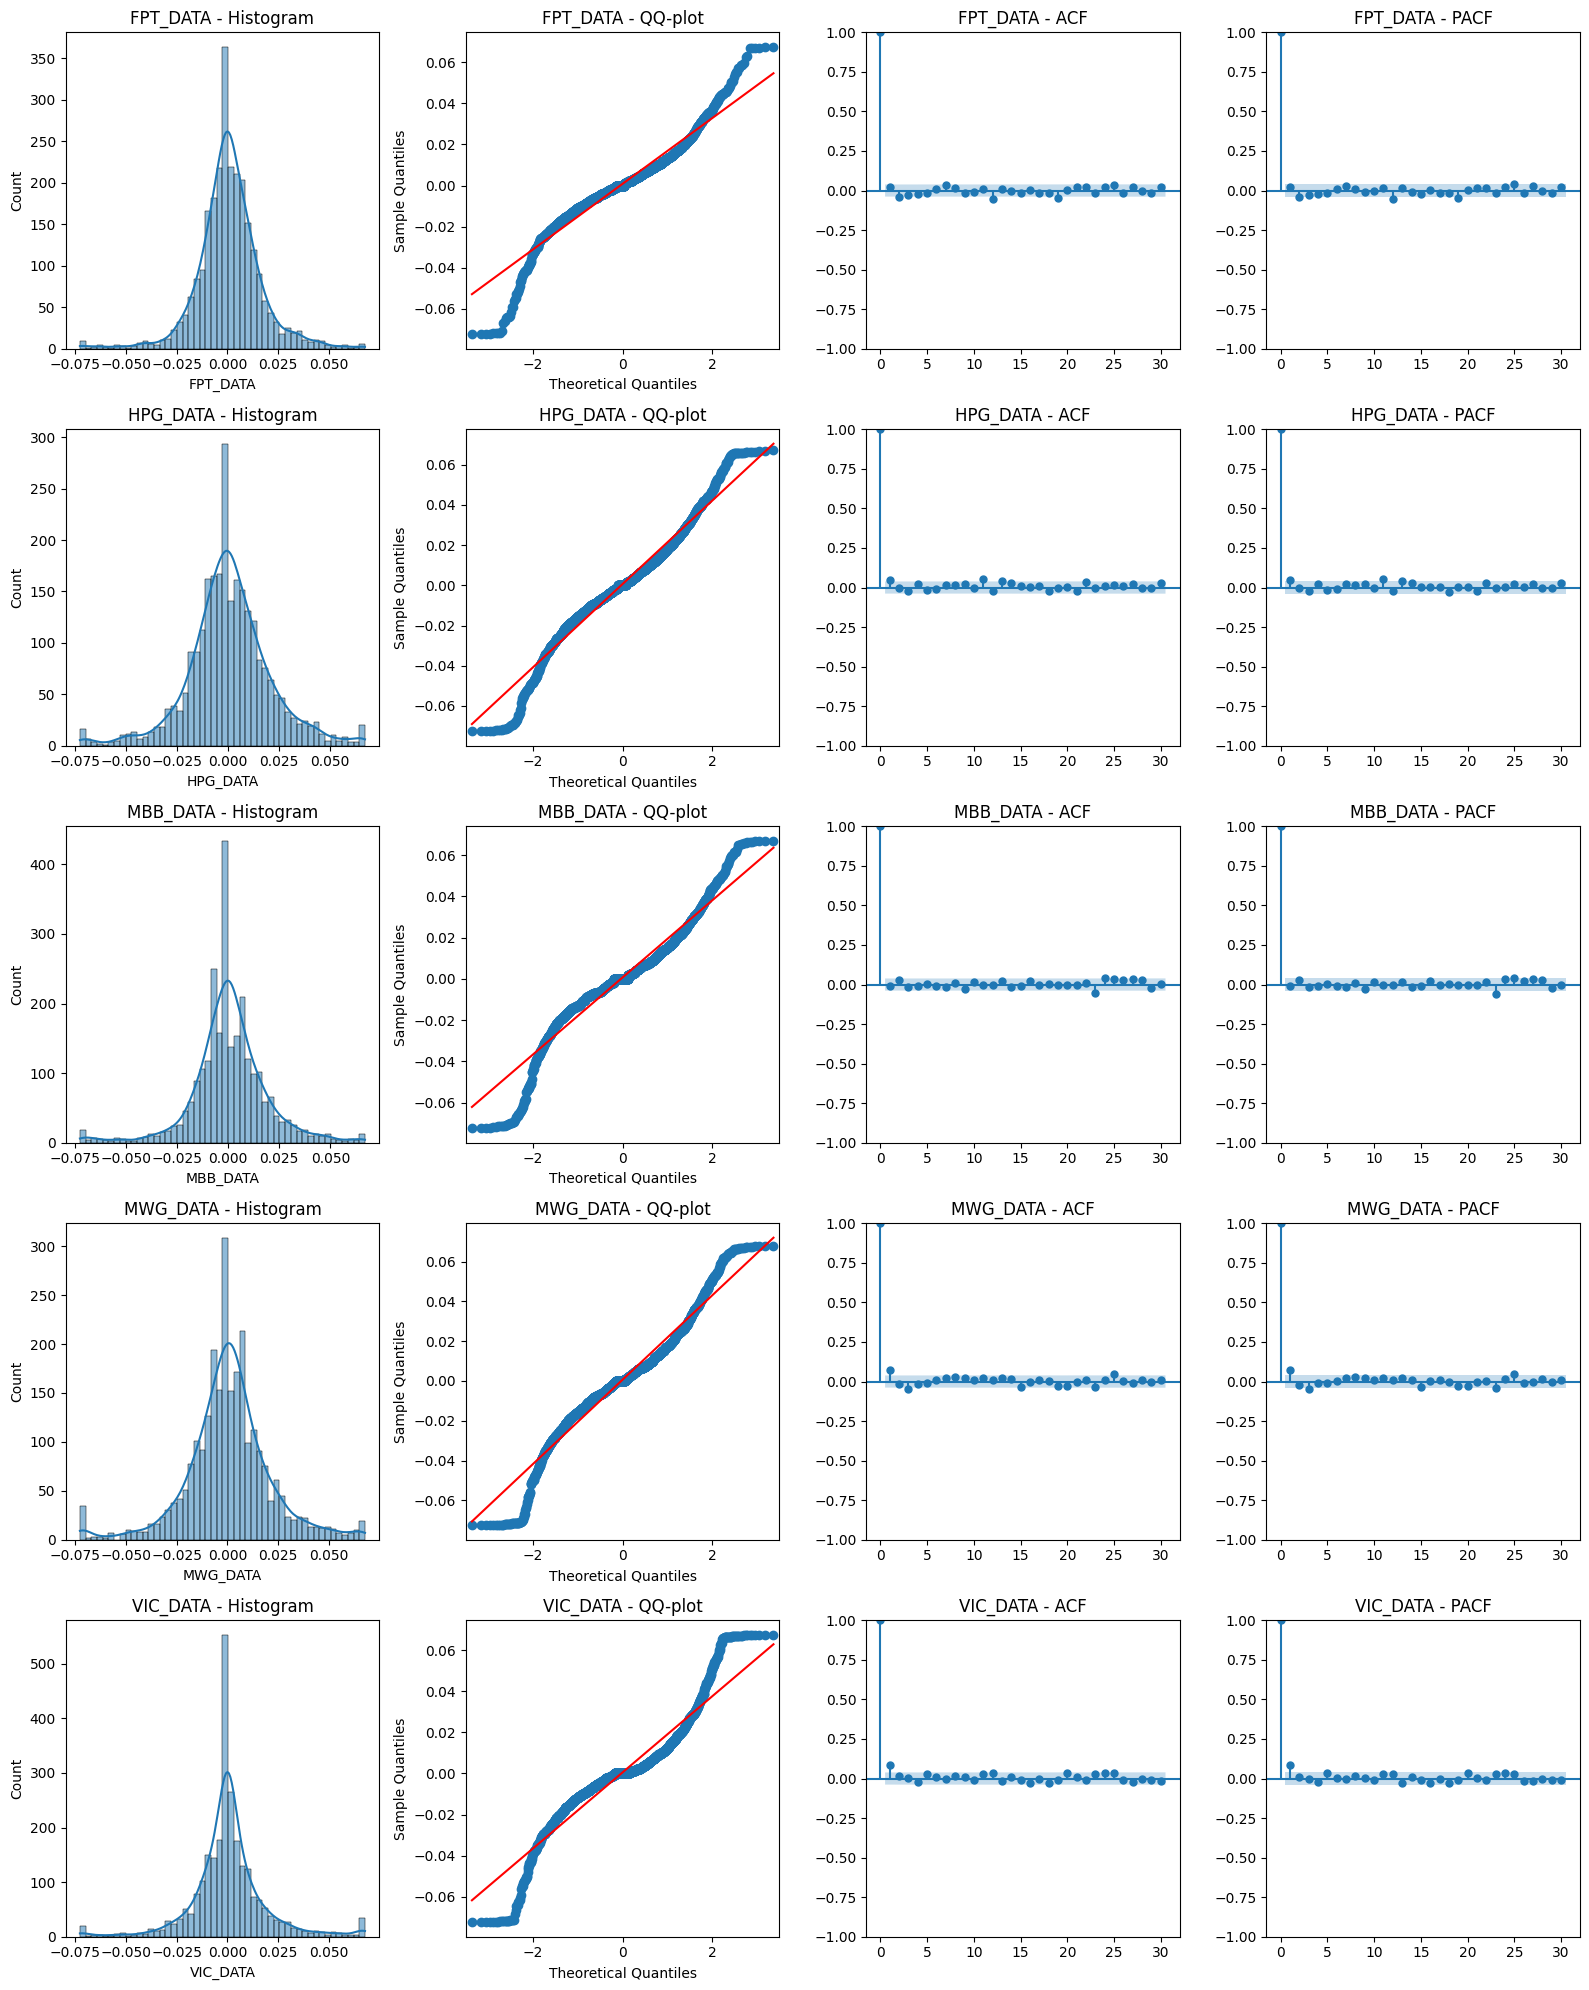

In [11]:
# Phân tích khám phá log returns cho từng cổ phiếu
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

tickers = log_returns.columns.tolist()
n_tickers = len(tickers)

# Tạo figure lớn cho tất cả biểu đồ
fig, axes = plt.subplots(n_tickers, 4, figsize=(16, 4*n_tickers))
if n_tickers == 1:
    axes = axes.reshape(1, -1)

for i, ticker in enumerate(tickers):
    data = log_returns[ticker].dropna()
    
    # Histogram
    sns.histplot(data, bins=50, kde=True, ax=axes[i,0])
    axes[i,0].set_title(f'{ticker} - Histogram')
    
    # QQ-plot
    sm.qqplot(data, line='s', ax=axes[i,1])
    axes[i,1].set_title(f'{ticker} - QQ-plot')
    
    # ACF
    plot_acf(data, ax=axes[i,2], lags=30)
    axes[i,2].set_title(f'{ticker} - ACF')
    
    # PACF
    plot_pacf(data, ax=axes[i,3], lags=30, method='ywm')
    axes[i,3].set_title(f'{ticker} - PACF')

plt.tight_layout()
plt.show()

- Tổng quan 5 mã (FPT, HPG, MBB, MWG, VIC): lợi suất ngày có đỉnh nhọn ở tâm, đuôi bè rõ rệt → phân phối leptokurtic (đuôi dày), không tuân theo phân phối chuẩn. Điều này phản ánh đặc trưng của thị trường tài chính Việt Nam: đa số ngày biến động nhỏ, nhưng vẫn tồn tại nhiều ngày cực trị.

- **Histogram:** Các cột tần suất tập trung mạnh quanh 0, nhưng có đuôi hai phía rõ rệt. Điều này cho thấy số lượng ngày biến động lớn (outlier) nhiều hơn so với kỳ vọng từ phân phối chuẩn. Fat tails là dấu hiệu của rủi ro cực đoan, cần chú ý khi xây dựng mô hình quản trị rủi ro.

- **QQ-plot:** Các điểm dữ liệu lệch khỏi đường chéo ở hai đầu, một số mã có sự bất đối xứng nhẹ. Điều này bác bỏ giả định phân phối chuẩn, gợi ý nên sử dụng các phân phối Student-t hoặc skew-t để mô phỏng returns. Sự bất đối xứng cho thấy có thể xuất hiện tail risk ở một phía (giảm mạnh hoặc tăng mạnh).

- **ACF/PACF của returns (đến lag 30):** Gần như không có tự tương quan tuyến tính đáng kể, các giá trị ACF/PACF dao động quanh 0. Điều này cho thấy returns gần như độc lập theo thời gian, phù hợp với giả thuyết thị trường hiệu quả. Mean model có thể chỉ cần hằng số, hoặc AR rất thấp nếu cần bổ sung.

**Kết luận:**
- Dữ liệu log returns của các mã blue-chip Việt Nam có đặc điểm fat tails, bất đối xứng nhẹ, và không có autocorrelation rõ rệt. Đây là lý do cần các mô hình GARCH/EVT để mô phỏng volatility clustering và tail risk, đồng thời sử dụng các phân phối linh hoạt hơn chuẩn để phản ánh thực tế thị trường.

### Statistical Tests - Kiểm định Tính chất Dữ liệu

In [21]:
from scipy.stats import normaltest, jarque_bera
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import adfuller

results = []
for ticker in log_returns.columns:
    x = log_returns[ticker].dropna()
    dag_stat, dag_p = normaltest(x)
    jb_stat, jb_p = jarque_bera(x)
    arch_stat, arch_p, _, _ = het_arch(x)
    adf_stat, adf_p, _, _, _, _ = adfuller(x)
    results.append({
        'Ticker': ticker,
        'D’Agostino p-value': round(dag_p, 3),
        'Jarque-Bera p-value': round(jb_p, 3),
        'ARCH p-value': round(arch_p, 3),
        'ADF p-value': round(adf_p, 3),
    })

test_results = pd.DataFrame(results).set_index('Ticker')
test_results

,D’Agostino p-value,Jarque-Bera p-value,ARCH p-value,ADF p-value
Ticker,,,,
FPT_DATA,0.0,0.0,0.0,0.0
HPG_DATA,0.0,0.0,0.0,0.0
MBB_DATA,0.0,0.0,0.0,0.0
MWG_DATA,0.0,0.0,0.0,0.0
VIC_DATA,0.0,0.0,0.0,0.0


### Diễn giải kết quả kiểm định thống kê (Normality, ARCH, Stationarity)
- Bảng trên cho thấy tất cả các mã đều có p-value = 0 ở các kiểm định D’Agostino, Jarque-Bera, ARCH, và ADF.

- **D’Agostino & Jarque-Bera (Normality):**
  - p-value = 0 cho tất cả mã nghĩa là log returns KHÔNG tuân theo phân phối chuẩn. Đây là đặc trưng phổ biến của dữ liệu tài chính thực tế, phản ánh sự tồn tại của fat tails và outliers.

- **ARCH Test (Volatility Clustering):**
  - p-value = 0 cho thấy có hiện tượng volatility clustering (ARCH effect) ở tất cả các mã. Điều này đồng nghĩa với việc biến động không đều theo thời gian, có những giai đoạn thị trường biến động mạnh và giai đoạn ổn định. Cần sử dụng các mô hình GARCH để mô phỏng và dự báo volatility.

- **ADF Test (Stationarity):**
  - p-value = 0 cho thấy log returns là stationary, tức là các đặc tính thống kê (mean, variance) không thay đổi theo thời gian. Đây là điều kiện tốt để áp dụng các mô hình chuỗi thời gian như GARCH/EVT.

**Kết luận:**
- Dữ liệu log returns của các mã blue-chip Việt Nam không chuẩn, có volatility clustering, và là stationary. Điều này xác nhận sự cần thiết của các mô hình GARCH/EVT để mô phỏng rủi ro và biến động thực tế trên thị trường.

### Kết quả kiểm định Ljung-Box (Autocorrelation)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = [10, 20, 30]
rows = []
for tk in log_returns.columns:
    x = log_returns[tk].dropna()
    lb_r = acorr_ljungbox(x, lags=lags, return_df=True)['lb_pvalue'].tolist()
    lb_r2 = acorr_ljungbox(x**2, lags=lags, return_df=True)['lb_pvalue'].tolist()
    rows.append([tk] + lb_r + lb_r2)

cols = ['Ticker'] + [f'LB_ret_p(lag{l})' for l in lags] + [f'LB_sq_p(lag{l})' for l in lags]
lb_table = pd.DataFrame(rows, columns=cols).set_index('Ticker')
lb_table

,LB_ret_p(lag10),LB_ret_p(lag20),LB_ret_p(lag30),LB_sq_p(lag10),LB_sq_p(lag20),LB_sq_p(lag30)
Ticker,,,,,,
FPT_DATA,0.178052,0.049735,0.057880,1.057314e-94,1.255244e-116,5.204760e-125
HPG_DATA,0.251649,0.077967,0.141024,1.751372e-138,2.796954e-173,1.314594e-209
MBB_DATA,0.663215,0.951863,0.261653,6.823803e-159,1.203909e-209,1.248186e-242
MWG_DATA,0.002592,0.010074,0.018316,1.232417e-156,2.067139e-182,6.942870e-190
VIC_DATA,0.005785,0.005479,0.009492,1.840660e-168,1.147797e-185,8.201423e-198


- Bảng trên trình bày p-value của kiểm định Ljung-Box cho returns (LB_ret_p) và squared returns (LB_sq_p) ở các độ trễ 10, 20, 30.

- **LB_ret_p (returns):**
  - Đa số mã có p-value > 0.05 ở lag 10, 20, 30 (trừ MWG, VIC), nghĩa là returns không có autocorrelation rõ rệt, phù hợp với giả thuyết thị trường hiệu quả. Tuy nhiên, MWG và VIC có p-value < 0.05 ở các lag, cho thấy có thể tồn tại một chút predictability hoặc hiệu ứng động lượng ngắn hạn.

- **LB_sq_p (squared returns):**
  - Tất cả các mã đều có p-value cực nhỏ (≈ 0) ở mọi lag, chứng tỏ squared returns có autocorrelation rất mạnh. Đây là dấu hiệu rõ rệt của volatility clustering: biến động lớn thường đi kèm nhau theo chuỗi, không xuất hiện ngẫu nhiên.

**Ý nghĩa:**
- Returns gần như không có autocorrelation, nhưng squared returns lại có autocorrelation rất mạnh. Điều này xác nhận đặc trưng volatility clustering của dữ liệu tài chính, và là lý do cần sử dụng các mô hình GARCH để mô phỏng và dự báo biến động.
- Khi xây dựng mô hình, nên chú trọng đến modeling volatility (GARCH/EGARCH) hơn là modeling mean (ARMA), vì mean gần như không có predictability nhưng volatility lại có cấu trúc phụ thuộc theo thời gian.

### Biểu đồ time series log returns của các cổ phiếu

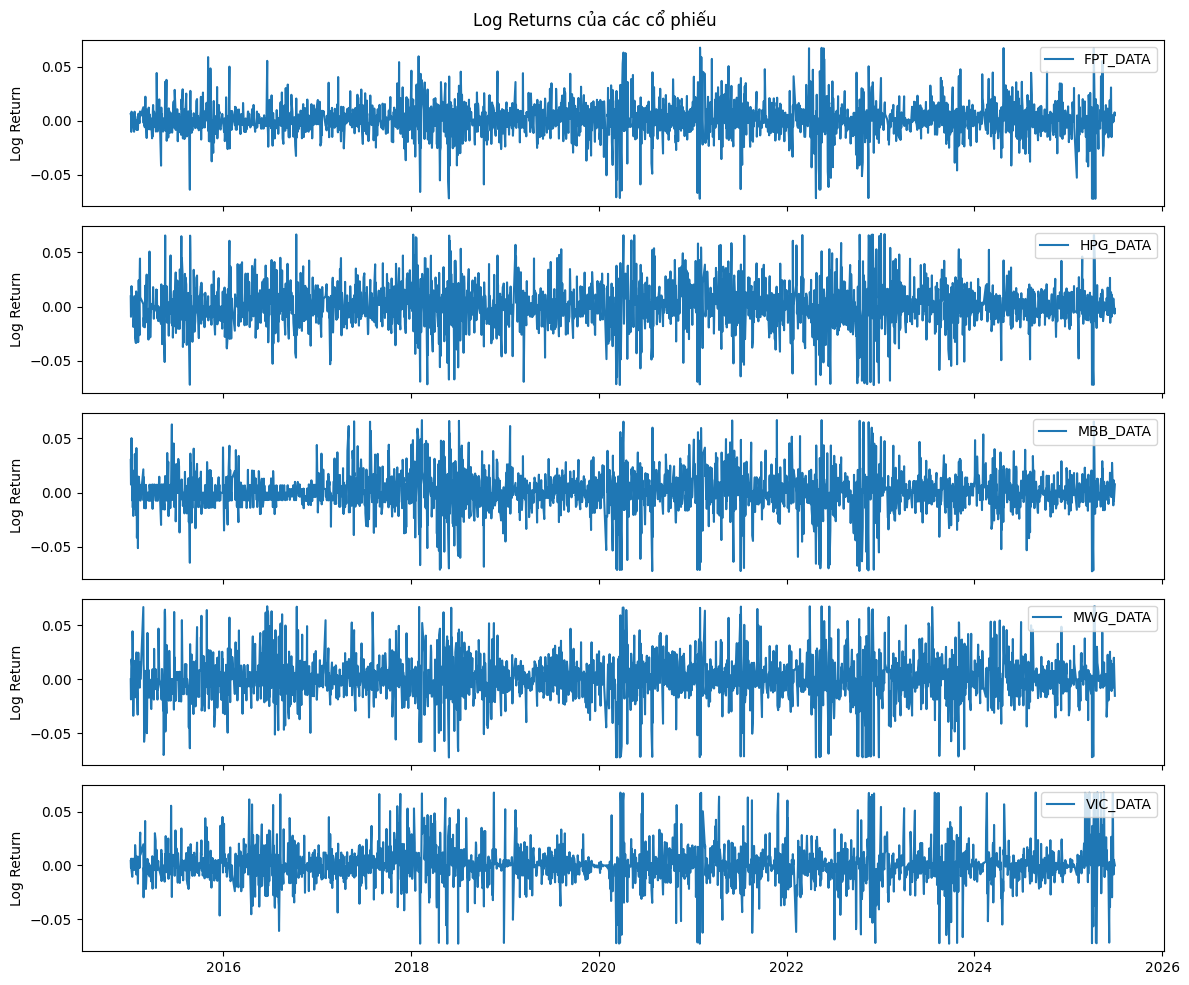

In [13]:
fig, axes = plt.subplots(len(tickers), 1, figsize=(12, 2*len(tickers)), sharex=True)
for i, ticker in enumerate(tickers):
    axes[i].plot(log_returns.index, log_returns[ticker], label=ticker)
    axes[i].set_ylabel('Log Return')
    axes[i].legend(loc='upper right')
plt.suptitle('Log Returns của các cổ phiếu')
plt.tight_layout()
plt.show()

- Biểu đồ trên thể hiện log returns của từng mã cổ phiếu qua thời gian. Có thể thấy rõ đặc trưng volatility clustering: các giai đoạn biến động mạnh thường tập trung thành cụm, xen kẽ với các giai đoạn ổn định hơn.

- Các đỉnh và đáy lớn xuất hiện không đều, phản ánh tail risk và sự xuất hiện của các sự kiện cực đoan (crisis, tin tức lớn, v.v.).
- Đa số thời gian, returns dao động quanh 0 với biên độ nhỏ, nhưng vẫn có những ngày biến động rất mạnh, đặc biệt ở các mã như MWG, HPG, VIC.

**Ý nghĩa:**
- Volatility clustering là đặc trưng quan trọng của dữ liệu tài chính, cho thấy biến động không xuất hiện ngẫu nhiên mà có tính chuỗi.
- Khi xây dựng mô hình quản trị rủi ro hoặc dự báo, cần chú trọng đến modeling volatility và tail risk, không chỉ dựa vào trung bình returns.

### Diễn giải bảng Risk Metrics (VaR, Sharpe, Autocorr, Số ngày tăng/giảm)
- Bảng dưới trình bày các chỉ số rủi ro và hiệu suất đầu tư cho từng mã cổ phiếu: VaR_5%, Sharpe ratio, autocorr_lag1, số ngày tăng (num_pos), số ngày giảm (num_neg).

In [14]:
# Thống kê mở rộng cho log returns
def calc_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats['VaR_5%'] = df.quantile(0.05)
    stats['sharpe'] = df.mean() / df.std()
    stats['autocorr_lag1'] = df.apply(lambda x: x.autocorr(lag=1))
    stats['num_pos'] = (df > 0).sum()
    stats['num_neg'] = (df < 0).sum()
    return stats.round(6)

desc_stats_ext = calc_stats(log_returns)
desc_stats_ext

,VaR_5%,sharpe,autocorr_lag1,num_pos,num_neg
FPT_DATA,-0.022332,0.055136,0.019952,1269,1152
HPG_DATA,-0.032161,0.033008,0.045284,1237,1207
MBB_DATA,-0.027493,0.040662,-0.009519,1185,1102
MWG_DATA,-0.032300,0.032242,0.071939,1257,1150
VIC_DATA,-0.026922,0.031793,0.085796,1142,1123


- **VaR_5%:**
  - Giá trị VaR đều âm, cho thấy trong 5% trường hợp xấu nhất, các mã có thể mất từ 2.2% đến 3.2% trong một ngày. HPG và MWG có VaR thấp nhất (rủi ro tail lớn nhất), FPT an toàn hơn.

- **Sharpe Ratio:**
  - Tất cả các mã đều có Sharpe ratio thấp (<0.1), phản ánh hiệu suất đầu tư điều chỉnh rủi ro chưa cao trong giai đoạn này. FPT có Sharpe cao nhất, VIC thấp nhất.

- **Autocorr_lag1:**
  - Giá trị autocorrelation lag 1 đều gần 0, cho thấy returns gần như không có tính dự báo từ ngày trước đó. VIC và MWG có autocorr dương cao nhất, MBB có autocorr âm nhẹ (mean reversion).

- **Num_pos/num_neg:**
  - Số ngày tăng/giảm khá cân bằng, tỷ lệ ~50/50 đúng với đặc trưng của thị trường hiệu quả. Không có mã nào lệch quá nhiều về một phía.

**Nhận xét tổng quan:**
- HPG và MWG là hai mã có rủi ro tail lớn nhất (VaR thấp nhất), FPT an toàn hơn và hiệu suất đầu tư tốt hơn (Sharpe cao nhất).
- Returns của các mã gần như không có autocorrelation, xác nhận tính ngẫu nhiên của biến động ngắn hạn.
- Số ngày tăng/giảm cân bằng, không có bias rõ rệt trong sample period.
- Khi xây dựng chiến lược đầu tư hoặc quản trị rủi ro, nên chú ý đến VaR và Sharpe để so sánh mức độ rủi ro/lợi nhuận giữa các mã.

### Biểu đồ số ngày log return dương và âm

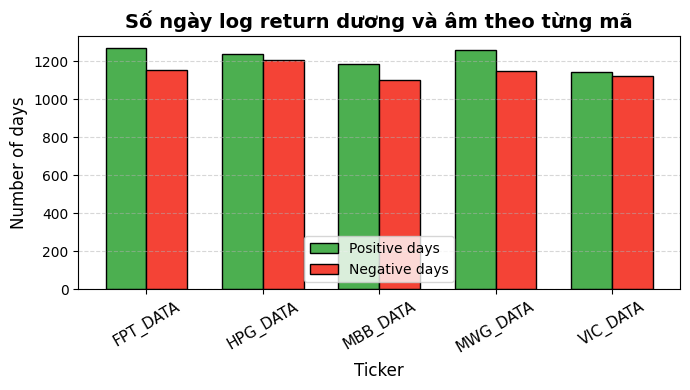

In [15]:
import matplotlib.pyplot as plt

# Tính số ngày positive và negative cho từng mã
num_pos = (log_returns > 0).sum()
num_neg = (log_returns < 0).sum()

# Vẽ biểu đồ bar với màu sắc đẹp hơn
fig, ax = plt.subplots(figsize=(7, 4))
bar_width = 0.35
index = np.arange(len(log_returns.columns))

ax.bar(index, num_pos, bar_width, label='Positive days', color='#4CAF50', edgecolor='black')
ax.bar(index + bar_width, num_neg, bar_width, label='Negative days', color='#F44336', edgecolor='black')

ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Number of days', fontsize=12)
ax.set_title('Số ngày log return dương và âm theo từng mã', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(log_returns.columns, rotation=30, fontsize=11)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

- Biểu đồ trên cho thấy số ngày log return dương và âm của từng mã cổ phiếu gần như cân bằng, phản ánh đặc trưng thị trường hiệu quả: xác suất tăng/giảm mỗi ngày xấp xỉ 50/50.
- Không có mã nào lệch hẳn về một phía, cho thấy không có xu hướng tăng hoặc giảm kéo dài trong sample period.
- Đây là đặc điểm thường gặp ở dữ liệu log returns, phù hợp với giả định random walk và xác nhận tính ngẫu nhiên của biến động ngắn hạn.

### Kết quả ma trận tương quan log returns

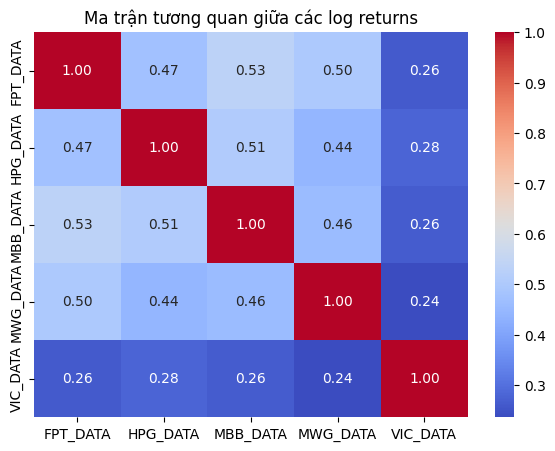

In [16]:
# 1. Ma trận tương quan
corr_matrix = log_returns.corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các log returns")
plt.show()

Ma trận tương quan trên cho thấy mức độ liên hệ giữa các cổ phiếu trong mẫu nghiên cứu:
- FPT, HPG, MBB, MWG có tương quan vừa phải với nhau (0.44–0.53), phản ánh các mã này có thể cùng chịu ảnh hưởng bởi yếu tố thị trường chung hoặc vĩ mô.
- VIC có tương quan thấp nhất với các mã còn lại (~0.24–0.28), cho thấy VIC biến động khá độc lập, có thể do đặc thù ngành hoặc yếu tố riêng.
- Không có cặp nào có tương quan quá cao (>0.7), điều này tốt cho đa dạng hóa danh mục đầu tư.
- Các giá trị dương cho thấy các mã thường biến động cùng chiều, nhưng mức độ liên hệ không quá mạnh.
Kết quả này giúp xác định nhóm cổ phiếu có thể cùng chịu rủi ro hệ thống và nhóm có tiềm năng đa dạng hóa khi xây dựng danh mục.

### Scatter plot matrix log returns

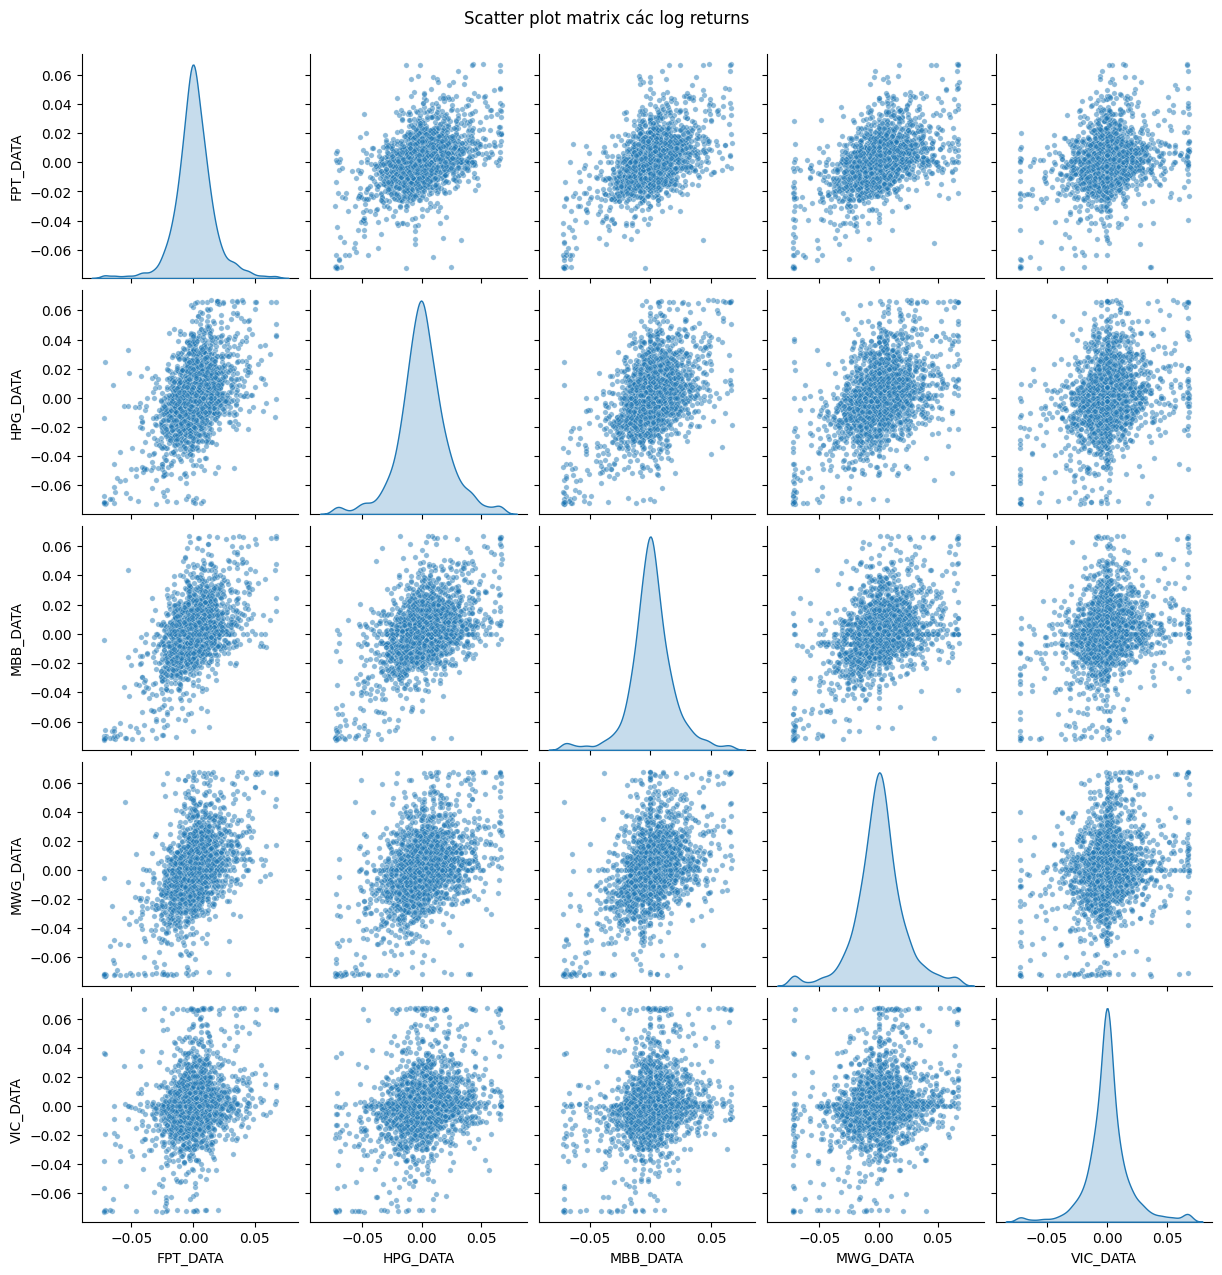

In [17]:
# 2. Biểu đồ phân tán (scatter plot matrix)
sns.pairplot(log_returns, diag_kind='kde', plot_kws={'alpha':0.5, 's':15})
plt.suptitle("Scatter plot matrix các log returns", y=1.02)
plt.show()

- Đường chéo cho thấy phân phối log returns của từng mã: đều có đỉnh nhọn ở tâm, đuôi dày, xác nhận đặc trưng fat tails và outlier.
- Các ô ngoài đường chéo cho thấy mối quan hệ giữa các cặp mã: đa số là mây phân tán, không có pattern rõ rệt, xác nhận tương quan vừa phải và không có phụ thuộc phi tuyến mạnh.
- VIC có mây phân tán rộng nhất với các mã khác, phù hợp với kết quả ma trận tương quan (VIC biến động độc lập hơn).
- Scatter plot matrix giúp kiểm tra nhanh tính đa dạng hóa và phát hiện các cặp cổ phiếu có thể cùng chịu ảnh hưởng chung.

### Rolling correlation giữa các cặp cổ phiếu
Biểu đồ rolling correlation (100 ngày) cho thấy mức độ tương quan giữa các cặp cổ phiếu thay đổi theo thời gian, không cố định.

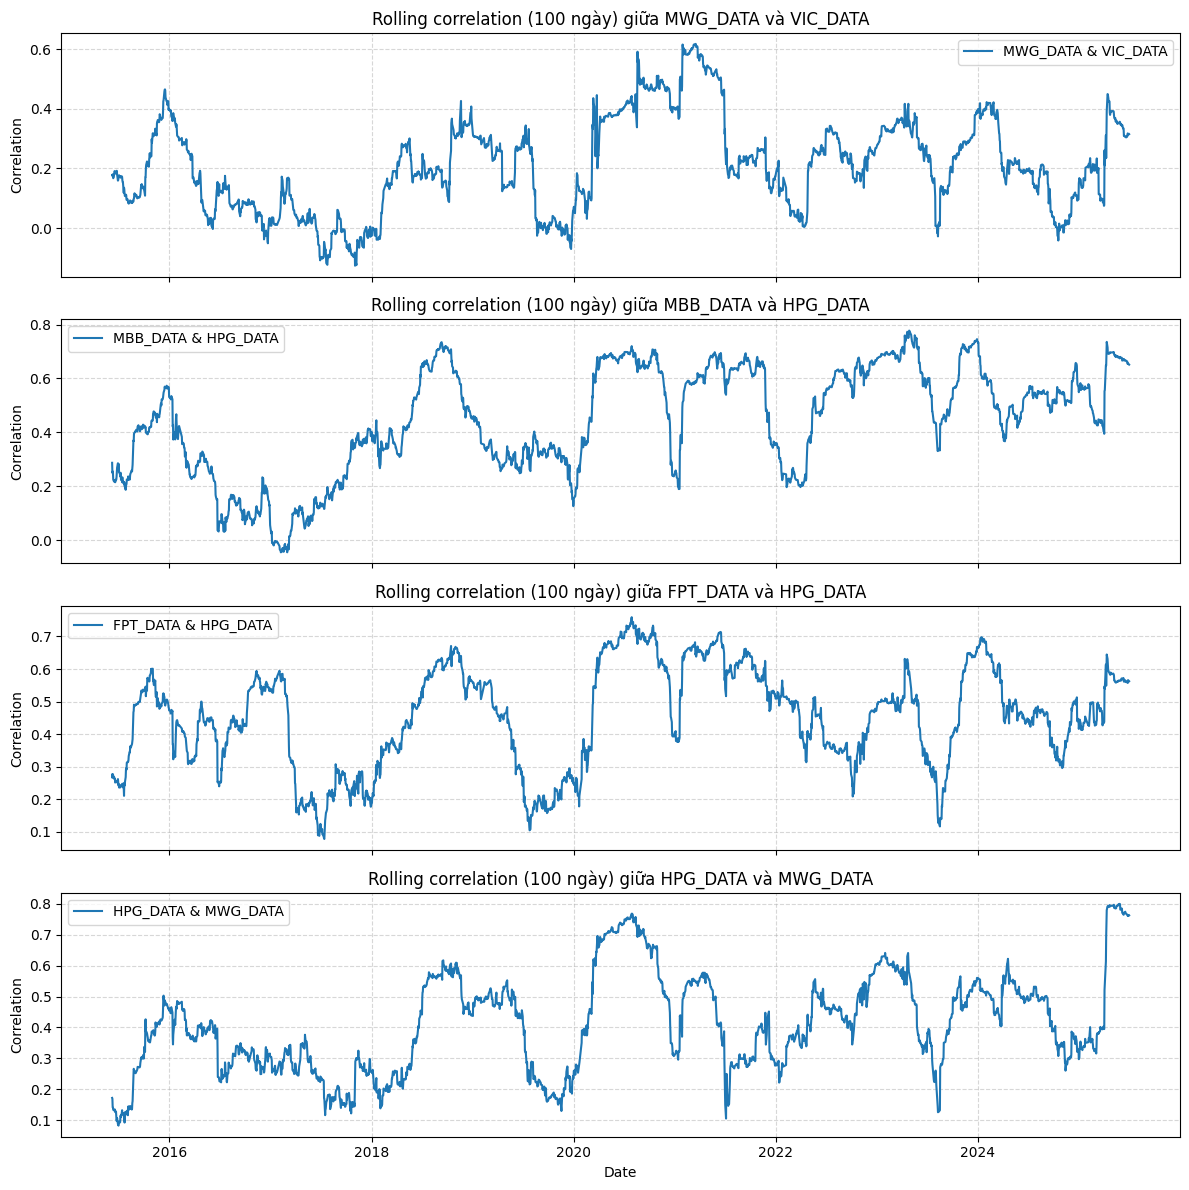

In [39]:
window = 100
pairs = [('MWG_DATA', 'VIC_DATA'), ('MBB_DATA', 'HPG_DATA'), ('FPT_DATA', 'HPG_DATA'), ('HPG_DATA', 'MWG_DATA')]

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
for i, pair in enumerate(pairs):
    rolling_corr = log_returns[pair[0]].rolling(window).corr(log_returns[pair[1]])
    axes[i].plot(rolling_corr, label=f'{pair[0]} & {pair[1]}')
    axes[i].set_title(f'Rolling correlation ({window} ngày) giữa {pair[0]} và {pair[1]}')
    axes[i].set_ylabel('Correlation')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

- Có những giai đoạn tương quan tăng cao (thường khi thị trường biến động mạnh hoặc có sự kiện chung), xen kẽ với giai đoạn tương quan giảm.
- MBB_DATA & HPG_DATA, FPT_DATA & HPG_DATA, HPG_DATA & MWG_DATA có lúc tương quan lên đến 0.7–0.8, nhưng cũng có lúc giảm về 0.2–0.3, cho thấy hiệu quả đa dạng hóa không ổn định.
- MWG_DATA & VIC_DATA có tương quan thấp hơn, biến động nhẹ hơn so với các cặp còn lại.
- Việc rolling correlation biến động cho thấy rủi ro hệ thống có thể thay đổi theo chu kỳ thị trường, cần theo dõi khi xây dựng chiến lược đầu tư và quản trị rủi ro.